In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as smp
from tqdm import tqdm
from sympy import Symbol, symbols
from pathlib import Path
import centrex_TlF as centrex
import matplotlib.pyplot as plt
from julia import Main

In [2]:
syspars = centrex.states.SystemParameters(
    nprocs  = 7,
    Γ       = 2*np.pi*1.56e6,
    ground  = [centrex.states.QuantumSelector(J=2, electronic = 'X'),
               centrex.states.QuantumSelector(J=4, electronic = 'X')],
    excited = centrex.states.QuantumSelector(J=2, F=2, F1=5/2, P=-1, electronic = 'B')
)

In [3]:
odepars = centrex.lindblad.odeParameters(
    Ωl = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δl      = 0,              # detuning of the laser [rad/s]
    
    # laser phase modulation
    ωphase = syspars.Γ,       # laser phase modulation frequency [rad/s]
    β      = 3.8,             # laser phase modulation depth [rad]

    # laser polarization switching
    ωp = 2*np.pi*1.56e6,           # polarization switching frequency [rad/s]
    φp = 0.0,                 # polarization switching phase [rad]
    Pl  = "sin(ωp*t + φp)",
    Plz = "Pl>0",
    Plx = "Pl<=0",
    
    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

# notice the optional declaration of the main states for the ground and excited states, this will be the
# main transition used if entered, otherwise a main transition is automatically chosen.
transitions = [
    centrex.couplings.TransitionSelector(
        ground               = 1*centrex.states.generate_coupled_states_ground_X(syspars.ground[0]),
        excited              = 1*centrex.states.generate_coupled_states_excited_B(syspars.excited),
        polarizations        = [[1,0,0], [0,0,1]],
        polarization_symbols = symbols("Plx     Plz"),
        Ω                    = Symbol('Ωl', complex = True),
        δ                    = Symbol('δl'),
        description          = "laser transition",
       # ground_main          = 1*centrex.states.generate_coupled_states_ground_X(syspars.ground[0])[-3],
       # excited_main         = 1*centrex.states.generate_coupled_states_excited_B(syspars.excited)[-4]
    )
]

In [4]:
# Note qn_compact, this takes a QuantumSelector object which specifies a set of quantum numbers to compact into
# a single state, in this case the J=3 hyperfine levels. Since J=3 is just a decay channel for this system we
# don't care which specific hyperfine levels it decays into.
obe_system = centrex.lindblad.setup_OBE_system_julia(syspars, odepars, transitions, verbose=True, full_output=True, 
                                                     qn_compact=centrex.states.QuantumSelector(J=4, electronic = 'X'))

INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 7 cores
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 7 processes


In [5]:
obe_system.H_symbolic

Matrix([
[                         0,                          0,                          0,                         0,                         0,                         0,                          0,                         0,                        0,                        0,                        0,                         0,                         0,                        0,                         0,                         0,                         0,                         0,                         0,                         0,                0, -0.499999999999998*Plx*Ωl,  0.499843776839964*Plz*Ωl,  0.203996592473839*Plx*Ωl,                         0,                        0],
[                         0,           10.0265808105469,                          0,                         0,                         0,                         0,                          0,                         0,                        0,                        0,                        0

In [6]:
odepars.Ωl0 = 0.5*syspars.Γ
odepars.ωphase = 0
odepars.ωp = 1*syspars.Γ

In [7]:
ρ = centrex.utils.generate_population_states(centrex.states.QuantumSelector(J=2, electronic = 'X').get_indices(obe_system.QN), len(obe_system.QN))
t_array, results = centrex.lindblad.do_simulation_single(odepars, (0,200e-6), ρ)

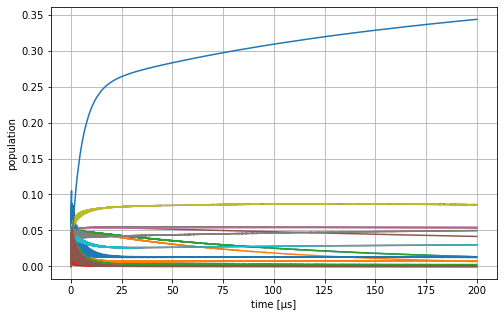

In [8]:
fig, ax = plt.subplots(figsize = (8,5)) 
ax.plot(t_array*1e6, results.T);
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.grid(True)

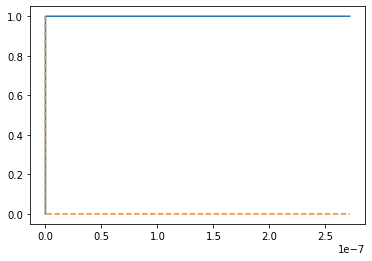

In [9]:
zpol = odepars.get_parameter_evolution(t_array, 'Plz').astype(bool)
xpol = odepars.get_parameter_evolution(t_array, 'Plx').astype(bool)
plt.plot(t_array[:100], zpol[:100])
plt.plot(t_array[:100], xpol[:100], '--')

In [10]:
Plz, Plx, Ωl, δl, Ωlc = list(obe_system.H_symbolic.free_symbols)

In [11]:
valsz, vecsz = np.linalg.eig(np.array(obe_system.H_symbolic.subs([(Plz,1),(Plx,0),(δl,0),(Ωl,odepars.Ωl0),(Ωlc,odepars.Ωl0)]), dtype = complex))
valsx, vecsx = np.linalg.eig(np.array(obe_system.H_symbolic.subs([(Plx,1),(Plz,0),(δl,0),(Ωl,odepars.Ωl0),(Ωlc,odepars.Ωl0)]), dtype = complex))

In [12]:
obe_system.H_symbolic.subs([(Plz,1),(Plx,0),(δl,0),(Ωl,odepars.Ωl0),(Ωlc,odepars.Ωl0)])

Matrix([
[               0,                0,                0,                0,                0,                0,                0,                 0,                0,                0,                0,                 0,                 0,                0,                 0,                 0,                 0,                 0,                 0,                0,                0,                0,                0,               0,                0,                0],
[               0, 10.0265808105469,                0,                0,                0,                0,                0,                 0,                0,                0,                0,                 0,                 0,                0,                 0,                 0,                 0,                 0,                 0,                0,                0,                0,                0,               0,                0,                0],
[               0,                0, 

In [13]:
cor = np.zeros(obe_system.H_symbolic.shape, dtype = complex)
for i,vz in enumerate(vecsz.T):
    for j,vx in enumerate(vecsx.T):
        cor[i,j] = (vz[:-3]@vx[:-3])

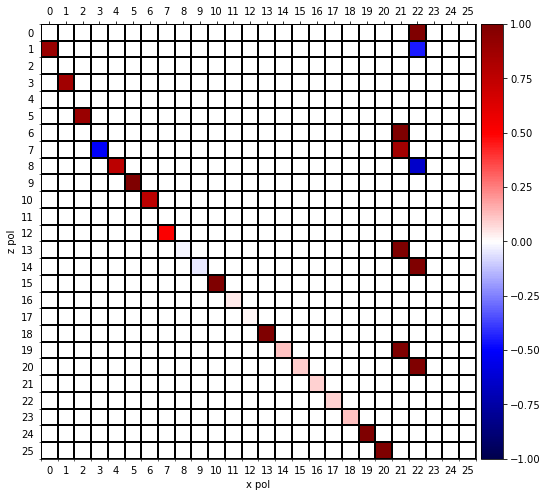

In [14]:
tolerance = 1e-5
import matplotlib as mpl
cmap = mpl.cm.get_cmap("seismic")

tmp = cor.copy()
tmp[tmp == 0] = np.nan
tmp[np.abs(tmp) < tolerance] = np.nan

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xlabel('x pol')
ax.set_ylabel('z pol')

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

In [ ]:
transformed = np.zeros(results.shape)
transformed[:,zpol] = np.diagonal((np.linalg.inv(vecsz)@(np.array(Main.eval("sol[:]"))[zpol]@vecsz)).real, axis1 = 1, axis2 = 2).T
transformed[:,xpol] = np.diagonal((np.linalg.inv(vecsx)@(np.array(Main.eval("sol[:]"))[xpol]@vecsx)).real, axis1 = 1, axis2 = 2).T

In [ ]:
cmap = mpl.cm.get_cmap("tab20")
fig, ax = plt.subplots(figsize = (16,10))
for idx in range(16):
    ax.plot(t_array[zpol], transformed.T[zpol][:,idx], color = cmap(idx), lw = 3);
    #ax.plot(t_array[xpol], transformed.T[xpol][:,idx], '--', color = cmap(idx), lw = 3)
ax.grid(True);

In [ ]:
tolerance = 1e-5
tmp = vecsz.copy()
tmp[np.abs(tmp) < tolerance] = 0
darkz = np.nansum(tmp[-3:,:]**2, axis = 0) < tolerance

In [18]:
labels = [f"F$_1$={qn.F1}, F={int(qn.F)}, mF={int(qn.mF)}" if qn.J != 4 else "J=4" for qn in [qn.find_largest_component() for qn in  obe_system.QN]]

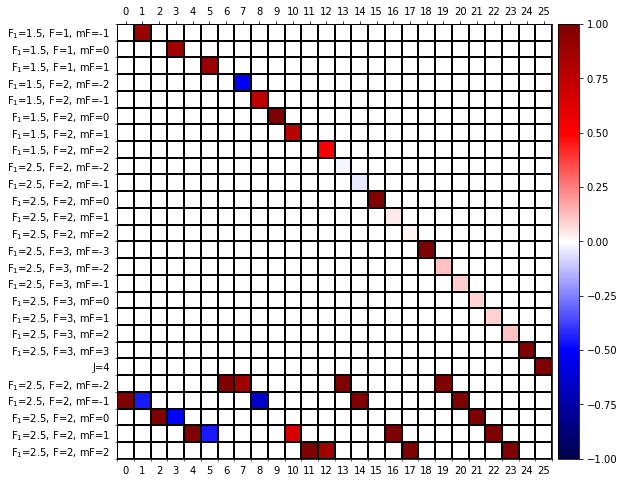

In [19]:
tolerance = 1e-10
import matplotlib as mpl
cmap = mpl.cm.get_cmap("seismic")

tmp = vecsz.copy()
tmp[tmp == 0] = np.nan
tmp[np.abs(tmp) < tolerance] = np.nan

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

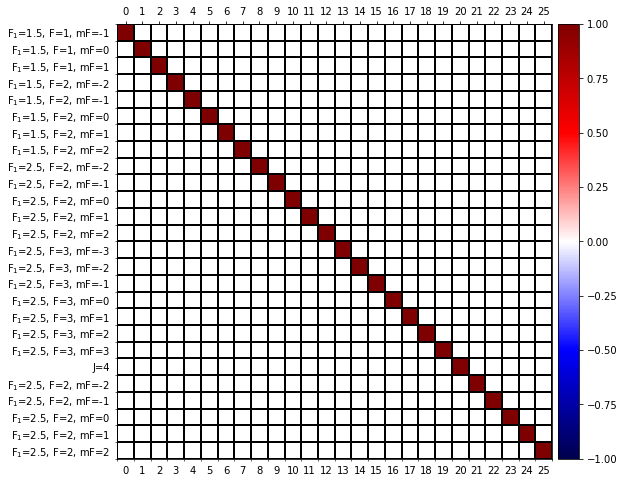

In [20]:
tolerance = 1e-10
import matplotlib as mpl
cmap = mpl.cm.get_cmap("seismic")

tmp = vecsx.copy()
tmp[tmp == 0] = np.nan
tmp[np.abs(tmp) < tolerance] = np.nan

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

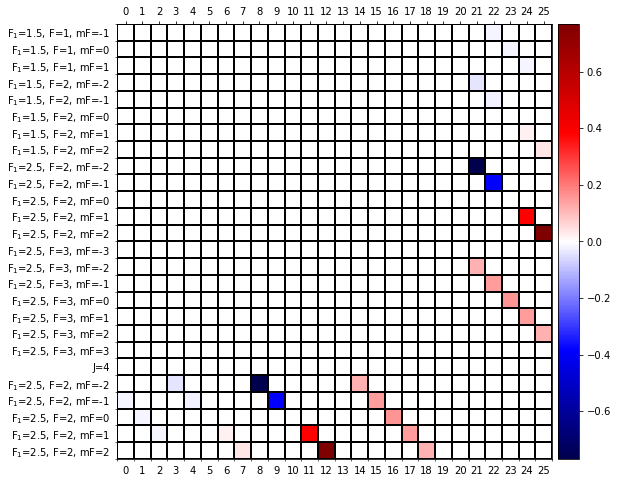

In [21]:
ind_delete = centrex.states.QuantumSelector(J=4, electronic = 'X').get_indices(obe_system.QN_original)[1:]
tmp = obe_system.couplings[0]['fields'][1]['field'].copy()
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, ind_delete, axis = 0)
tmp = np.delete(tmp, ind_delete, axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

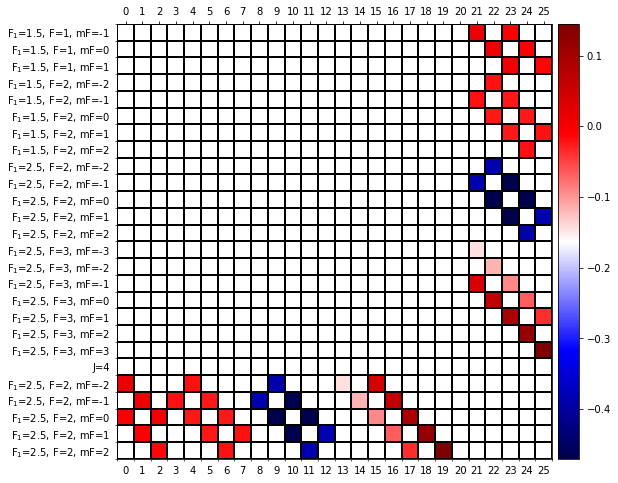

In [22]:
tmp = obe_system.couplings[0]['fields'][0]['field'].copy()
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, ind_delete, axis = 0)
tmp = np.delete(tmp, ind_delete, axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

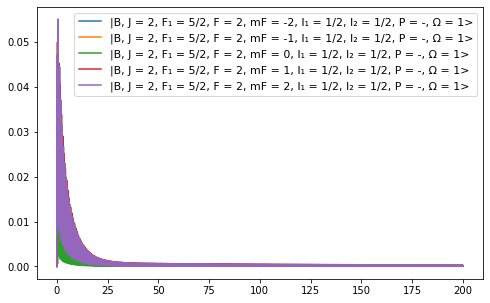

In [23]:
indices_excited = syspars.excited.get_indices(obe_system.QN)
fig, ax = plt.subplots(figsize = (8,5))
for idx in indices_excited:
    ax.plot(t_array*1e6, results[idx], label = obe_system.QN[idx].find_largest_component());

ax.legend(fontsize = 11)

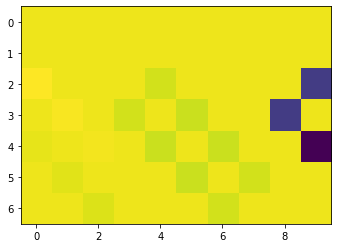

In [24]:
plt.imshow((obe_system.couplings[0]['fields'][0]['field'][-7:,:10]).real)